# User-to-User Similarity Script
This script utilizes the sklearn feature extraction package *DictVectorizer*
>Link to DictVectorizer documentation: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html

Section 2's code cells are callable functions to add reproducability on different, or multiple, datasets. To adjust inputs (data and parameters), changes are only required in section 2. 

### Imports

In [12]:
import json # load data
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
from sklearn.feature_extraction import DictVectorizer # convert json data to matrix format
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split

# Section 1: Callable Functions

#### Cosine similarity variations
Three different cosine similarity formulas are applied here and then evaluated to see which performs best. The 3 variations are: 
1. **Standard Cosine Similarity**  
$$
\text{cosine}(u, v) = \frac{u \cdot v}{\|u\| \cdot \|v\|}
$$

2. **Scaled Cosine Similarity**  
$$
\text{scaled_cosine}(u, v) = \text{cosine}(u, v) \cdot \min\left( \frac{\|u\|}{\|v\|}, \frac{\|v\|}{\|u\|} \right)
$$

3. **Soft Cosine Similarity** (with tunable exponent $ \alpha $)  
$$
\text{soft_cosine}_\alpha(u, v) = \frac{u \cdot v}{\|u\|^\alpha \cdot \|v\|^\alpha}, \quad \alpha \in [0, 1]
$$

Each variation attempts to balance vector directionality with magnitude in different ways. Standard Cosine Similarity only considers the direction of user vectors, while Scaled Cosine and Soft Cosine also consider vector magnitude. The soft cosine introduces a tunable parameter $ \alpha $ that interpolates between pure dot product ($ \alpha = 0 $) and standard cosine similarity ($ \alpha = 1 $).

<span style="color:blue">

Nick's Notes (temp):
> scaled cosine will ALWAYS produce a raw cosine score that is less than or equal to the standard cosine score. 
    
> soft cosine inflates the raw scores, so the printed raw scores are often larger than 100%

In [2]:
# ### load the data ### 
# def load_pseudo_users(json_paths):
#     all_users = []
#     for path in json_paths:
#         with open(path, "r") as f:
#             data = json.load(f)
#             all_users.extend(data)
#     return all_users


# ### build the user matrix from artist counts ### 
# def build_artist_vectors(user_json):
#     user_ids = []
#     artist_count_dicts = []

#     for user in user_json:
#         user_id = user["username"]
#         artist_counter = Counter()

#         for playlist in user["playlists"]:
#             for track in playlist["tracks"]:
#                 artist_uri = track["artist_uri"]
#                 artist_counter[artist_uri] += 1

#         user_ids.append(user_id)
#         artist_count_dicts.append(dict(artist_counter))

#     vectorizer = DictVectorizer(sparse=False)
#     matrix = vectorizer.fit_transform(artist_count_dicts)
#     artist_df = pd.DataFrame(matrix, index=user_ids, columns=vectorizer.get_feature_names_out())
#     return artist_df

# ##########################################################################################
# ##########################################################################################

# ### compute standard cosine similarity matrix (baseline) ###
# def compute_cosine_similarity(artist_df):
#     sim_matrix = cosine_similarity(artist_df.values)
#     return pd.DataFrame(sim_matrix, index=artist_df.index, columns=artist_df.index)


# ### compute scaled cosine similarity matrix ###
# def get_scaled_cosine_similarity(artist_df):
#     X = artist_df.values
#     sim_matrix = cosine_similarity(X) # get standard cosine matrix
    
#     # calculate norms of vectors from the artist df
#     norms = np.linalg.norm(X, axis=1)
#     norm_ratios = np.minimum.outer(norms, norms) / np.maximum.outer(norms, norms)
    
#     # multiply standard cosine matrix by norm matrix 
#     scaled_sim = sim_matrix * norm_ratios
#     return pd.DataFrame(scaled_sim, index=artist_df.index, columns=artist_df.index)


# ### compute soft cosine similarity matrix ###
# def get_soft_cosine_similarity(artist_df, alpha=1.0):
#     X = artist_df.values
    
#     # numerator: compute dot product
#     dot = X @ X.T
    
#     # denominator: compute norms and raise to alpha
#     norms = np.linalg.norm(X, axis=1)
#     norm_matrix = np.outer(norms, norms) ** alpha
    
#     # calculate final soft cosine
#     soft_cosine = dot / norm_matrix
#     np.fill_diagonal(soft_cosine, 1.0)
    
#     return pd.DataFrame(soft_cosine, index=artist_df.index, columns=artist_df.index)

# ##########################################################################################
# ##########################################################################################

# ### get similarity scores for a given user or pair of users ### 
# def get_user_similarity(df, user1, user2=None, top_x=5):
#     """
#     Parameters:
#         df (pd.DataFrame): similarity df
#         user1 (str) : The first user's ID.
#         [OPTIONAL] user2 (str): The second user's ID for comparing a pair
#         top_x (int): Number of top similar users to return if user2 is not provided
#     Returns:
#         pd.Series or float
#     """
#     if user1 not in df.index:
#         raise ValueError(f"User {user1} not found")
#     if user2:
#         if user2 not in df.columns:
#             raise ValueError(f"User {user2} not found")
#         return df.loc[user1, user2].round(3)
#     else:
#         top_users = df.loc[user1].drop(user1).sort_values(ascending=False).head(top_x)
#         return top_users.round(3)
    
    
# ### transform raw cosine score to user interpretable value ### 
# def transform_match_score(scores, df, include_raw=False):
#     """
#     Converts raw similarity score(s) into interpretable match score(s).
    
#     Parameters:
#         scores (float or pd.Series): Output from `get_user_similarity()`
#         df (pd.DataFrame): similarity df
#         score_type (str): Return 3 transformed (user interpretable) score
#                 1) raw cosine score x100
#                 2) min-max scaled (0–1) then ×100
#                 3) percentile rank value
    
#     Returns:
#         float or pd.Series of interpreted match scores
#     """
#     # triu_indices_from grabs only upper triangle and exclude diagonal
#     all_scores = df.values[np.triu_indices_from(df, k=1)]  
#     min_score = all_scores.min()
#     max_score = all_scores.max()

#     def interpret(score, user_label=None):
#         # raw score x 100
#         raw_score = round(score * 100, 1)
        
#         # min max scaled score x 100
#         scaled_score = (score - min_score) / (max_score - min_score)
#         scaled_score = round(scaled_score*100,1)
        
#         # percentile rank score (inverted to show top %)
#         rank = (all_scores < score).sum()
#         percentile_score = round(100*rank / len(all_scores), 1)
#         top_percentile_score = round(100 - percentile_score,1)
        
#         base_return = f"{scaled_score}% match, placing you in the top {top_percentile_score}% of user similarities"
#         if include_raw:
#             base_return += f" (Raw score of {raw_score}%)"
#         if user_label:
#             return f"- {user_label}: {base_return}"
#         return base_return
        
#     if isinstance(scores, pd.Series):
#         lines = [interpret(score, user_label=user) for user, score in scores.items()]
#         return f"\n".join(lines)
#     else:
#         return interpret(scores)


In [127]:
class UserSimilarityEvaluator:
    def __init__(self, json_paths, similarity_method="standard", soft_alpha=1.0):
        valid_methods = {"standard", "scaled", "soft"}
        self.similarity_method = similarity_method.lower()
        if method not in valid_methods:
            raise ValueError(f"Invalid similarity method: '{similarity_method}'. Choose from {valid_methods}")

        self.json_paths = json_paths
        self.similarity_method = similarity_method
        self.soft_alpha = soft_alpha
        self.pseudo_users = []
        self.artist_df = None
        self.similarity_df = None
        self.eval_log = []
    
    ### load the data ### 
    def load_data(self):
        self.pseudo_users = []
        for path in self.json_paths:
            with open(path, "r") as f:
                data = json.load(f)
                self.pseudo_users.extend(data)
    
    ### data test-train split ###
    def split_train_test(self, test_frac=0.2, seed=6740):
        train_users = []
        test_users = []
        for user in self.pseudo_users:
            playlists = user["playlists"]
            if len(playlists) < 2:
                continue  # skip users with too few playlists
            train, test = train_test_split(playlists, test_size=test_frac, random_state=seed)
            train_users.append({"username": user["username"], "playlists": train})
            test_users.append({"username": user["username"], "playlists": test})
        return train_users, test_users

    ### build the user matrix from artist counts ### 
    def build_artist_vectors(self, user_json):
        user_ids = []
        artist_count_dicts = []

        for user in self.pseudo_users:
            user_id = user["username"]
            artist_counter = Counter()

            for playlist in user["playlists"]:
                for track in playlist["tracks"]:
                    artist_uri = track["artist_uri"]
                    artist_counter[artist_uri] += 1

            user_ids.append(user_id)
            artist_count_dicts.append(dict(artist_counter))

        vectorizer = DictVectorizer(sparse=False)
        matrix = vectorizer.fit_transform(artist_count_dicts)
        return pd.DataFrame(matrix, index=user_ids, columns=vectorizer.get_feature_names_out())

    ### compute standard cosine similarity matrix (baseline) ###
    def compute_similarity(self, artist_df):
        if self.similarity_method == 'standard':
            sim_matrix = cosine_similarity(artist_df.values)
            
        ### compute scaled cosine similarity matrix ###
        elif self.similarity_method == 'scaled':
            X = artist_df.values
            sim_matrix = cosine_similarity(X) # get standard cosine matrix
            # calculate norms of vectors from the artist df
            norms = np.linalg.norm(X, axis=1)
            norm_ratios = np.minimum.outer(norms, norms) / np.maximum.outer(norms, norms)
            # multiply standard cosine matrix by norm matrix 
            sim_matrix = sim_matrix * norm_ratios
            np.fill_diagonal(sim_matrix,1.0)
            
        ### compute soft cosine similarity matrix ###
        elif self.similarity_method == 'soft':
            X = artist_df.values
            # numerator: compute dot product
            dot = X @ X.T
            # denominator: compute norms and raise to alpha
            norms = np.linalg.norm(X, axis=1)
            norm_matrix = np.outer(norms, norms) ** self.soft_alpha
            # calculate final soft cosine
            sim_matrix = dot / norm_matrix
            np.fill_diagonal(sim_matrix, 1.0)
            
        else:
            raise ValueError("Invalid similarity method.")
            
        return pd.DataFrame(sim_matrix, index=artist_df.index, columns=artist_df.index)
    
    ### get similarity scores for a given user or pair of users ### 
    def get_user_similarity(self, user1, user2=None, top_x=5):
        """
        Parameters:
            df (pd.DataFrame): similarity df
            user1 (str) : The first user's ID.
            [OPTIONAL] user2 (str): The second user's ID for comparing a pair
            top_x (int): Number of top similar users to return if user2 is not provided
        Returns:
            pd.Series or float
        """
        if user1 not in self.similarity_df.index:
            raise ValueError(f"User {user1} not found")
        if user2:
            if user2 not in self.similarity_df.columns:
                raise ValueError(f"User {user2} not found")
            return self.similarity_df.loc[user1, user2].round(3)
        else:
            top_users = self.similarity_df.loc[user1].drop(user1).sort_values(ascending=False).head(top_x)
            return top_users.round(3)


    ### transform raw cosine score to user interpretable value ### 
    def transform_match_score(self, scores, include_raw=False):
        """
        Converts raw similarity score(s) into interpretable match score(s).

        Parameters:
            scores (float or pd.Series): Output from `get_user_similarity()`
            df (pd.DataFrame): similarity df
            score_type (str): Return 3 transformed (user interpretable) score
                    1) raw cosine score x100
                    2) min-max scaled (0–1) then ×100
                    3) percentile rank value

        Returns:
            float or pd.Series of interpreted match scores
        """
        # triu_indices_from grabs only upper triangle and exclude diagonal
        all_scores = self.similarity_df.values[np.triu_indices_from(self.similarity_df, k=1)]  
        min_score = all_scores.min()
        max_score = all_scores.max()

        def interpret(score, user_label=None):
            # raw score x 100
            raw_score = round(score * 100, 1)
            # min max scaled score x 100
            scaled_score = (score - min_score) / (max_score - min_score)
            scaled_score = round(scaled_score*100,1)
            # percentile rank score (inverted to show top %)
            rank = (all_scores < score).sum()
            percentile_score = round(100*rank / len(all_scores), 1)
            top_percentile_score = round(100 - percentile_score,1)

            base_return = f"{scaled_score}% match, placing you in the top {top_percentile_score}% of user similarities"
            if include_raw:
                base_return += f" (Raw score of {raw_score}%)"
            if user_label:
                return f"- {user_label}: {base_return}"
            return base_return

        if isinstance(scores, pd.Series):
            lines = [interpret(score, user_label=user) for user, score in scores.items()]
            return "\n".join(lines)
        else:
            return interpret(scores)

    ### runs all necessary functions to test output ###
    def run_full_pipeline(self, test_frac=0.2, seed=6740):
        self.load_data()
        train_users, test_users = self.split_train_test(test_frac=test_frac, seed=seed)
        self.train_artist_df = self.build_artist_vectors(train_users)
        self.test_artist_df = self.build_artist_vectors(test_users)
        self.similarity_df = self.compute_similarity(self.train_artist_df)
#         self.eval_log.append({
#             "dataset": ", ".join(self.json_paths),
#             "method": self.similarity_method,
#             "alpha": self.soft_alpha if self.similarity_method == "soft" else None,
#             "train_users": len(train_users),
#             "test_users": len(test_users)
#         })
    
    ### evaluate performance ###
    def evaluate_sim(self, k=5, recall_at=100, print_score=False):
        recalls = []

        for user in self.test_artist_df.index:
            # get top-K similar users from train
            top_users = self.similarity_df.loc[user].drop(user).nlargest(k).index
            # aggregate user's artist counts
            combined_vector = self.train_artist_df.loc[top_users].sum(axis=0)
            top_n = min(recall_at, (combined_vector > 0).sum())  # prevent asking for more than exists
            predicted_artists = set(combined_vector.nlargest(top_n).index)
            # user's actual test artists
            actual_artists = set(self.test_artist_df.loc[user][self.test_artist_df.loc[user] > 0].index)
            
#             print(f"{user}: {len(predicted_artists)} predicted, {len(actual_artists)} actual")
            
            # compute recall metric
            if len(actual_artists) > 0:
                hits = predicted_artists.intersection(actual_artists)
                recall = len(hits) / len(actual_artists)
                recalls.append(recall)

        avg_recall = round(np.mean(recalls), 4)
        if print_score:
            print(f"Avg Recall@{k} using top {k} most similar users: {avg_recall}")
        return avg_recall

# Section 2: Testing and Evaluation - 6 Cases

In [128]:
### define test grid ###
json_configs = [
    ["data/pseudo-users-elbow-data.json"],
    ["data/psuedo-users-avg-playlists_data.json"]
]
methods = ["standard", "scaled", "soft"]
# methods = ["scaled"]
alphas = [None, None, np.arange(0.1, 1, 0.2)]  # soft cosine only
k_values = [1, 3, 5, 10, 15]
recall_at_values = [1, 5, 10, 15, 25, 50]

In [129]:
### run for all 6 cases ###
results = []

for json_paths, dataset_label in zip(json_configs, ["elbow", "avg_playlists"]):
    print(f"\n=== Running for {dataset_label.upper()} data ===")
    for method, alpha_list in zip(methods, alphas):
        print(f"\n   === Running {method.upper()} on {dataset_label}")
        if method == "soft":
            for alpha in alpha_list:
                model = UserSimilarityEvaluator(json_paths, similarity_method=method, soft_alpha=alpha)
                model.run_full_pipeline()
                for r in recall_at_values:
                    score = model.evaluate_sim(k=k, recall_at=r)
                    model.eval_log.append({
                        "dataset": ", ".join(json_paths),
                        "method": method,
                        "alpha": alpha,
                        "train_users": len(model.train_artist_df),
                        "test_users": len(model.test_artist_df),
                        "k_neighbors": k,
                        "recall_at": r,
                        "recall_score": score
                    })
                    results.append(model)
        else:
            model = UserSimilarityEvaluator(json_paths, similarity_method=method)
            model.run_full_pipeline()
            for k in k_values:
                for r in recall_at_values:
                    score = model.evaluate_sim(k=k, recall_at=r)
                    model.eval_log.append({
                        "dataset": ", ".join(json_paths),
                        "method": method,
                        "alpha": None,
                        "train_users": len(model.train_artist_df),
                        "test_users": len(model.test_artist_df),
                        "k_neighbors": k,
                        "recall_at": r,
                        "recall_score": score
                    })
                    results.append(model)


=== Running for ELBOW data ===

   === Running STANDARD on elbow

   === Running SCALED on elbow

   === Running SOFT on elbow

=== Running for AVG_PLAYLISTS data ===

   === Running STANDARD on avg_playlists

   === Running SCALED on avg_playlists

   === Running SOFT on avg_playlists


In [135]:
### evaluate cases and compare ###
summary = eval_df = pd.DataFrame([entry for model in results for entry in model.eval_log])
eval_df = eval_df.drop_duplicates()
eval_df.sort_values(by="recall_score", ascending=False).head(20)

,dataset,method,alpha,train_users,test_users,k_neighbors,recall_at,recall_score
1991,data/psuedo-users-avg-playlists_data.json,standard,NaN,43,43,3,50,0.0787
2897,data/psuedo-users-avg-playlists_data.json,scaled,NaN,43,43,5,50,0.0767
1997,data/psuedo-users-avg-playlists_data.json,standard,NaN,43,43,5,50,0.0765
2891,data/psuedo-users-avg-playlists_data.json,scaled,NaN,43,43,3,50,0.0757
2903,data/psuedo-users-avg-playlists_data.json,scaled,NaN,43,43,10,50,0.0743
1985,data/psuedo-users-avg-playlists_data.json,standard,NaN,43,43,1,50,0.0742
2003,data/psuedo-users-avg-playlists_data.json,standard,NaN,43,43,10,50,0.0739
2885,data/psuedo-users-avg-playlists_data.json,scaled,NaN,43,43,1,50,0.0702
2909,data/psuedo-users-avg-playlists_data.json,scaled,NaN,43,43,15,50,0.0701
2009,data/psuedo-users-avg-playlists_data.json,standard,NaN,43,43,15,50,0.0687


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


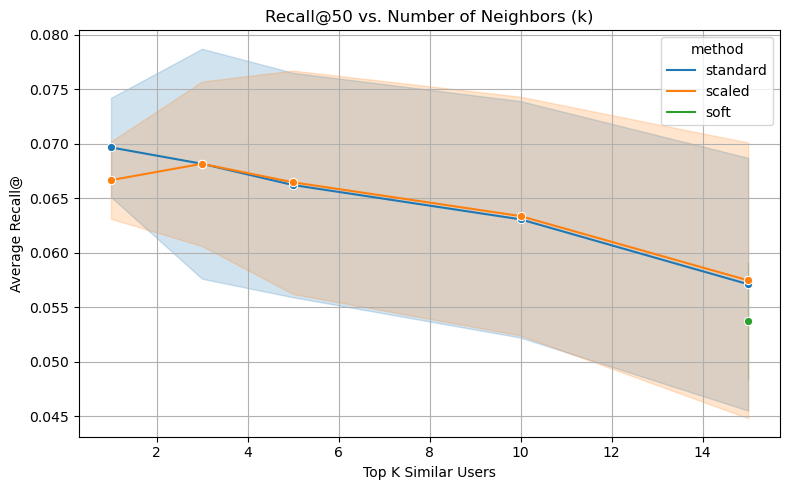

In [136]:
import matplotlib.pyplot as plt
import seaborn as sns

recall = 50

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=eval_df[eval_df["recall_at"] == recall],
    x="k_neighbors",
    y="recall_score",
    hue="method",
    marker="o"
)
plt.title(f"Recall@{recall} vs. Number of Neighbors (k)")
plt.xlabel("Top K Similar Users")
plt.ylabel("Average Recall@")
plt.grid(True)
plt.tight_layout()
plt.show()

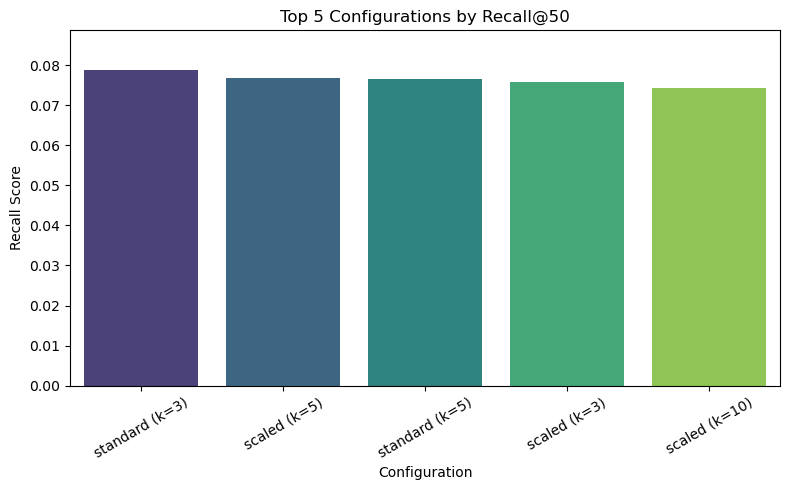

In [137]:
top5 = eval_df[eval_df["recall_at"] == recall].sort_values(by="recall_score", ascending=False).head(5).copy()
top5["label"] = top5.apply(
    lambda row: f"{row['method']} (k={int(row['k_neighbors'])})", axis=1
)

plt.figure(figsize=(8, 5))
sns.barplot(
    data=top5,
    x="label",
    y="recall_score",
    palette="viridis"
)
plt.title(f"Top 5 Configurations by Recall@{recall}")
plt.ylabel("Recall Score")
plt.xlabel("Configuration")
plt.xticks(rotation=30)
plt.ylim(0, top5["recall_score"].max() + 0.01)
plt.tight_layout()
plt.show()

### Intepretation of Evaluation Results

Scaled cosine consistently performs the best. Soft consine improves slightly with $ \alpha $, but never outperforms scaled or standard. 

## General Notes, Commentary, and Outcomes

### The Evaluation Strategy
The key output of the user-to-user similarity model is to find musically similar users. Once this is acheived, the challenge becomes how to evaluate its performance - especially since this is unsupervised learning task with no direct labels. 

To address this, we established a proxy evaluation strategy grounded in user behavior over time. Consider the following example: 
> First, we split each psuedo user's playlists into training and test sets. After constructing the similarity matrix from the training data, extract the top $ K $ most similar users to a given user A. If user A is musically similar to users B, C, and D, then B/C/D’s artist habits should be a good proxy for A’s *future* behavior. 

We can then combine the artist vector's for users B/C/D into a single aggregate vector, which acts as a "predicted" artist profile for user A. This vector represents what we think user A will enjoy in the future. Finally, we compare this predicted vector against the actual artist vector from user A’s test playlists. The saved test data reflects what user A actually listened to in the future. The key performance metric becomes the **fraction of true test artists that were recovered in the top-N predicted artists**,  also known as **Recall@N**. In other words, of the 100 artists predicted for user A, we calculate what fraction of their true test artists were included in the prediction.

#### Example:

Let’s say for 'user_0009':
- **Actual test artists**: ['Taylor Swift', 'Drake', 'Beyoncé']
- **Predicted top-100 artists (based on K similar users)**: ['Drake', 'Beyoncé', 'Kanye', ...]

Then:
- **Matches** = 2 (Drake, Beyoncé)
- **$\Rightarrow$ Recall@100** = $ \frac{2}{3} = 0.667 $

This process is repeated across all users, and the average Recall@100 is used to evaluate model performance.

$ \text{Recall} = \frac{\text{all hits}}{\text{all actual test artists}} $ 

## Usage 1: First 1000 playlists Elbow Method data | Standard Cosine

### *Similarity Matrix*

In [4]:
# ### creating similarity matrix ###
# json_paths = ["data/pseudo-users-elbow-data.json"]
# pseudo_users = load_pseudo_users(json_paths)
# artist_df = build_artist_vectors(pseudo_users)
# cosine_df = compute_cosine_similarity(artist_df)

# cosine_df.round(3).head()

### *Similarity between users*

In [5]:
# ### getting top 5 most similar users ###
# print("=== TOP 5 ===")
# print(get_user_similarity(cosine_df, user1="user_0009"))

# ### getting similarity between 2 users ###
# print("\n=== SIMILARITY BETWEEN 2 USERS ===")
# print(get_user_similarity(cosine_df, user1="user_0009", user2="user_0006"))

# ### get transformed scores for a single user ###
# print("\n=== TRANSFORMED TOP 5 ===")
# print(transform_match_score(get_user_similarity(cosine_df, user1="user_0009"), cosine_df, include_raw=True))

# ### get transformed scores for a user pair ###
# print("\n=== TRANSFORMED SIMILARITY BETWEEN 2 USERS ===")
# print(transform_match_score(get_user_similarity(cosine_df, user1="user_0009", user2="user_0006"), cosine_df))

## Usage 2: First 1000 playlists Elbow Method data | Scaled Cosine

### *Similarity Matrix*

In [6]:
# scaled_cosine_df = get_scaled_cosine_similarity(artist_df)

# scaled_cosine_df.round(3).head()

### *Similarity between users*

In [7]:
# ### getting top 5 most similar users ###
# print("=== TOP 5 ===")
# print(get_user_similarity(scaled_cosine_df, user1="user_0009"))

# ### getting similarity between 2 users ###
# print("\n=== SIMILARITY BETWEEN 2 USERS ===")
# print(get_user_similarity(scaled_cosine_df, user1="user_0009", user2="user_0006"))

# ### get transformed scores for a single user ###
# print("\n=== TRANSFORMED TOP 5 ===")
# print(transform_match_score(get_user_similarity(scaled_cosine_df, user1="user_0009"), scaled_cosine_df, include_raw=True))

# ### get transformed scores for a user pair ###
# print("\n=== TRANSFORMED SIMILARITY BETWEEN 2 USERS ===")
# print(transform_match_score(get_user_similarity(scaled_cosine_df, user1="user_0009", user2="user_0006"), scaled_cosine_df))

## Usage 3: First 1000 playlists Elbow Method data | Soft Cosine

### *Similarity Matrix*

In [8]:
# soft_cosine_df = get_soft_cosine_similarity(artist_df, alpha = 0.5)

# soft_cosine_df.round(3).head()

### *Similarity between users*

In [9]:
# ### getting top 5 most similar users ###
# print("=== TOP 5 ===")
# print(get_user_similarity(soft_cosine_df, user1="user_0009"))

# ### getting similarity between 2 users ###
# print("\n=== SIMILARITY BETWEEN 2 USERS ===")
# print(get_user_similarity(soft_cosine_df, user1="user_0009", user2="user_0006"))

# ### get transformed scores for a single user ###
# print("\n=== TRANSFORMED TOP 5 ===")
# print(transform_match_score(
#     get_user_similarity(soft_cosine_df, user1="user_0009"), soft_cosine_df, include_raw=True))

# ### get transformed scores for a user pair ###
# print("\n=== TRANSFORMED SIMILARITY BETWEEN 2 USERS ===")
# print(transform_match_score(
#     get_user_similarity(soft_cosine_df, user1="user_0009", user2="user_0006"), soft_cosine_df))